In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

import torch

from scipy import stats

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import stim_generation, models, analysis, importlib

In [2]:
# Configuration parameters
trained_cnn_path = './model/trained_cnn.pth.tar'
cuda = True # whether to run the CNN on cuda-supported GPU
batch_size = 32 # number of images for the CNN to process concurrently during inference

Qrange = np.array([0,1,2,3,4]) # range of tested numerosities
colors = ['red', 'orange', 'green', 'blue', 'purple'] # plotting colors for numerosities in Qrange
dot_radius = 18 # pixels; radius of individual dots in stimuli
hull_size = 3 # triangular convex hull in control dataset
stimulus_num_reps = 40 # number of stimuli per numerosity/control condition combination

matplotlib.rcParams.update({'font.size': 7.65}) # plot font size


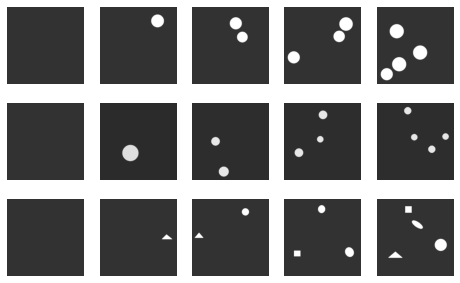

In [3]:
np.random.seed(12345) # fix random seed for repeatability
# generate stimuli:
#   S: array of size (num_images, 3, 224, 224) containing sampled stimuli
#   Q: numerosity depecited in each stimulus
#   C: condition under which each stimulus was generated
S, Q, C = stim_generation.generate_datasets(num_reps=stimulus_num_reps, Qrange=Qrange, radius=dot_radius, hull_size=hull_size)
stim_generation.plot_samples(S, Q, C, figsize=(8,5))

In [4]:
# Load trained CNN and discard classification layer
encoder = models.load_trained_model(trained_cnn_path, keep_classifier=False, add_noise_layers=True, noise_sigma=0.15)
if cuda: encoder.cuda()

In [5]:
# Run stimuli through CNN to get responses of final hidden layer
torch.manual_seed(12345) # fix random seed for repeatability
Hf = encoder.predict(S, verbose=True, cuda=cuda, batch_size=batch_size).numpy()
Hf = Hf.reshape(Hf.shape[0],-1)

In [6]:
# Find numorosity selective units (anova_cells) using a two-way ANOVA
pN, pC, pNC = analysis.anova_two_way(Q, C, Hf)
anova_cells = np.where((pN<0.01) & (pNC>0.01) & (pC>0.01))[0]
R = Hf[:,anova_cells]

Number of anova cells = 3939 (10.47%)


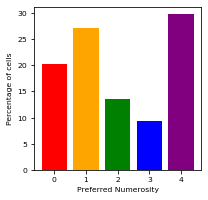

In [7]:
# Calculate and plot ditribution of preferred numerosities
pref_num = analysis.preferred_numerosity(Q, R)
hist = [np.sum(pref_num==q) for q in Qrange]
hist /= np.sum(hist)

plt.figure(figsize=(3,3))
plt.bar(Qrange, 100*hist, width=0.8, color=colors)
plt.xlabel('Preferred Numerosity')
plt.ylabel('Percentage of cells')
print('Number of anova cells = %i (%0.2f%%)'%(len(anova_cells), 100*len(anova_cells)/Hf.shape[1]))

For zero-tuned units: average response to 1 vs average response to 2: p-value = 5.114556e-118
For zero-tuned units: average response to 2 vs average response to 3: p-value = 3.136120e-96


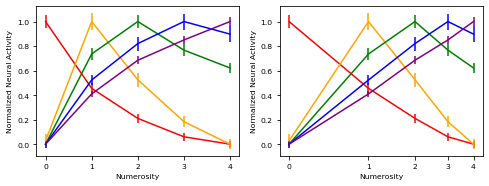

In [8]:
# Calculate average tuning curve of each unit
tuning_curves = analysis.average_tuning_curves(Q, R) 

# Calculate population tuning curves for each preferred numerosity
tuning_mat = np.array([np.mean(tuning_curves[:,pref_num==q], axis=1) for q in Qrange]) # one row for each pref numerosity
tuning_err = np.array([np.std(tuning_curves[:,pref_num==q], axis=1) / np.sqrt(np.sum(pref_num==q)) # standard error for each point on each tuning curve
                       for q in Qrange])

# Normalize population tuning curves to the 0-1 range
tmmin = tuning_mat.min(axis=1)[:,None]
tmmax = tuning_mat.max(axis=1)[:,None]
tuning_mat = (tuning_mat-tmmin) / (tmmax-tmmin)
tuning_err = tuning_err / (tmmax-tmmin) # scale standard error to be consistent with above normalization

# Plot population tuning curves on linear scale
plt.figure(figsize=(8,2.75))
plt.subplot(1,2,1)
for i, (tc, err) in enumerate(zip(tuning_mat, tuning_err)):
    plt.errorbar(Qrange, tc, err, color=colors[i])
    plt.xticks(Qrange)
plt.xlabel('Numerosity')
plt.ylabel('Normalized Neural Activity')

# Plot population tuning curves on log scale
plt.subplot(1,2,2)
for i, (tc, err) in enumerate(zip(tuning_mat, tuning_err)):
    plt.errorbar(Qrange+1, tc, err, color=colors[i]) # offset x axis by one to avoid taking the log of zero
    plt.xscale('log', base=2)
    plt.gca().xaxis.set_major_formatter(ScalarFormatter())
    plt.xticks(ticks=Qrange+1, labels=Qrange)
plt.xlabel('Numerosity')
plt.ylabel('Normalized Neural Activity')

# Average responses of zero-tuned units to numerosities 1, 2, and 3
R01 = tuning_curves[:,pref_num==0][1]
R02 = tuning_curves[:,pref_num==0][2]
R03 = tuning_curves[:,pref_num==0][3]

print('For zero-tuned units: average response to 1 vs average response to 2: p-value = %e'
           %(stats.wilcoxon(R01, R02).pvalue))

print('For zero-tuned units: average response to 2 vs average response to 3: p-value = %e'
           %(stats.wilcoxon(R02, R03).pvalue))

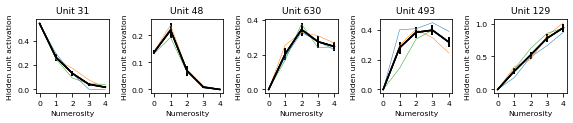

In [9]:
# Plot average tuning curves of representative units
rep_units = [31, 48, 630, 493, 129]
plt.figure(figsize=(8,1.75))
for i, unit in enumerate(rep_units):
    plt.subplot(1, len(rep_units), i+1)
    for j in np.unique(C):
        tc = np.array([R[(Q==q) & (C==j), unit].mean() for q in Qrange])
        plt.plot(Qrange, tc, linewidth=0.5)

        tc = np.array([R[(Q==q), unit].mean() for q in Qrange])
        err = np.array([R[(Q==q), unit].std() for q in Qrange]) / np.sqrt(np.sum((Q==Q[0])))
        plt.errorbar(Qrange, tc, err, color='k', linewidth=1.5)
        
        plt.xlabel('Numerosity'); plt.ylabel('Hidden unit activation')
        plt.title('Unit %i' %(unit,))
        plt.xticks(Qrange)

plt.tight_layout()

Linear vs log fit for zero: p = 8.672074653335023e-108


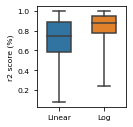

In [10]:
# Fit straight lines to tuning curves of zero-tuned units on linear and log scales
tuning_curves_zero = analysis.average_tuning_curves(Q, R[:,pref_num==0]).T
r2_linear = analysis.fit_tuning_curves_with_lines(tuning_curves_zero, Qrange+1)
r2_log = analysis.fit_tuning_curves_with_lines(tuning_curves_zero, np.log2(Qrange+1)) # offset x axis by one to avoid taking the log of zero

# Compare goodness-of-fit on linear and log scales
plt.figure(figsize=(1.6,1.85))
ax=sns.boxplot(data=[r2_linear, r2_log], whis=10, width=0.55)
ax.set(xticklabels=['Linear', 'Log'])
plt.ylabel('r2 score (%)')
print('Linear vs log fit for zero: p =', stats.wilcoxon(r2_linear, r2_log).pvalue)

In [11]:
# Constructs a matching task dataset
# Each stimulus is paired with a newly generated stimulus of either matching or non-matching numerosity (50% probability for each)
#   X: stimuli responses
#   Y: numerosity of each stimulus
def make_match_dataset(X, Y):
    YM = np.random.random(Y.shape)>0.5 # True of numerosity of stimulus pair is matched, false otherwise
    X2 = np.zeros_like(X) 
    Y2 = np.zeros_like(Y)

    # pre-generate stimuli to choose from when pairing given stimuli
    Xcands, Ycands, _ = stim_generation.generate_datasets(num_reps=stimulus_num_reps, Qrange=Qrange, radius=dot_radius, hull_size=hull_size)
    Hf = encoder.predict(Xcands, verbose=False, cuda=cuda, batch_size=batch_size).numpy()
    Hf = Hf.reshape(Hf.shape[0],-1)
    Xcands = Hf[:,anova_cells]
    
    for i in range(X.shape[0]):
        if not YM[i]:
            # choose a stimulus with non-matching numerosity
            candidates = np.setdiff1d(Qrange, [Y[i]]) 
            Y2[i] = np.random.choice(candidates)
        else:
            # choose a stimulus with the same numerosity
            Y2[i] = Y[i]
        
        idx = np.random.choice(np.where(Ycands==Y2[i])[0])
        X2[i] = Xcands[idx]
        
    return X2.astype(np.float32), Y2.astype(np.float32), YM

In [12]:
# Calculates the rate of a classifier predicting that two stimuli have matching numerosity as a function of the numerosity
#   Qtest: numerosity of first stimulus
#   Q2test: numerosity of second stimulus
#   QMPtest: classifier predicitions. True indicates matching, False indicate non-matching
def performance_tuning_functions(Qtest, Q2test, QMPtest):
    tuning_mat = np.nan * np.zeros((len(Qrange), len(Qrange)))

    for i, n1 in enumerate(Qrange):
        q2 = np.unique(Q2test[Qtest==n1])

        p = np.array([QMPtest[(Qtest==n1)&(Q2test==n2)].mean() for n2 in q2])
        tuning_mat[i, [np.where(Qrange==qq2)[0][0] for qq2 in q2]] = p

    return tuning_mat

In [13]:
# Runs numerosity matching and classification tasks for a given number of repetitions
def behavioral_perfomance_tests(num_reps, cmodel_data_split=0.5):
    tuning_mats = []                # performance tuning functions of matching task
    accuracies_matching = []        # matching task accuracy
    accuracies_matching_zero = []   # matching task accuracy for trials involving zero
    confusion_mats_correct = []     # classification task confusion matrices for correct trials of matching task
    confusion_mats_error = []       # classification task confusion matrices for error trials of matching task
    accuracies_correct = []         # classification task accuracy for correct trials of matching task
    accuracies_error = []           # classification task accuracy for error trials of matching task

    confusion_mats_zs = []          # classification task confusion matrices when zero-tuned units are silenced
    confusion_mats_rs = []          # classification task confusion matrices when random nonzero-tuned units are silenced

    for rep in range(num_reps):
        # Generate new stimuli for training and testing
        Strain, Qtrain, Ctrain = stim_generation.generate_datasets(num_reps=stimulus_num_reps, Qrange=Qrange, radius=dot_radius, hull_size=hull_size)
        Stest, Qtest, Ctest = stim_generation.generate_datasets(num_reps=stimulus_num_reps, Qrange=Qrange, radius=dot_radius, hull_size=hull_size)

        # Run them through the CNN and get responses of numerosity-selective units
        Hftrain = encoder.predict(Strain, verbose=False, cuda=cuda, batch_size=batch_size).numpy()
        Hftrain = Hftrain.reshape(Hftrain.shape[0],-1)
        Rtrain = Hftrain[:,anova_cells]
        Hftest = encoder.predict(Stest, verbose=False, cuda=cuda, batch_size=batch_size).numpy()
        Hftest = Hftest.reshape(Hftest.shape[0],-1)
        Rtest = Hftest[:,anova_cells]

        # Construct datasets for numerosity matching task
        R2train, Q2train, QMtrain = make_match_dataset(Rtrain, Qtrain)
        R2test, Q2test, QMtest = make_match_dataset(Rtest, Qtest)

        # Train an SVM to predict numerosity matching based on difference between responses of numerosity-selective units
        Dtrain = Rtrain - R2train
        Dtest = Rtest - R2test
        match_model = SVC(C=1.0)
        match_model.fit(Dtrain, QMtrain)

        # Evaluate SVM on matching test set and keep track of correct and error trials
        accuracy = match_model.score(Dtest, QMtest)
        QMPtest = match_model.predict(Dtest)
        correct_trials = np.where(QMtest==QMPtest)[0]
        error_trials = np.where(QMtest!=QMPtest)[0]
        
        # Record performance tuning functions and matching accuracy
        tuning_mats.append(performance_tuning_functions(Qtest, Q2test, QMPtest))
        accuracies_matching.append(accuracy)

        # Record accuracy for trials involving zero
        zero_trials = np.where((Qtest==0) | (Q2test==0))[0]; 
        accuracies_matching_zero.append(match_model.score(Dtest[zero_trials], QMtest[zero_trials]))
        
        # Training and testing data for classification model
        Ntrain = int(cmodel_data_split * len(correct_trials))
        # Training data from correct trials of matching task. Train on both stimuli from each trial
        cmRtrain         = np.concatenate((Rtest[correct_trials][:Ntrain], R2test[correct_trials][:Ntrain]), axis=0)
        cmQtrain         = np.concatenate((Qtest[correct_trials][:Ntrain], Q2test[correct_trials][:Ntrain]), axis=0)
        
        # Testing data from correct trials
        cmRtest_correct  = np.concatenate((Rtest[correct_trials][Ntrain:], R2test[correct_trials][Ntrain:]), axis=0)
        cmQtest_correct  = np.concatenate((Qtest[correct_trials][Ntrain:], Q2test[correct_trials][Ntrain:]), axis=0)
        
        # Testing data from error trials
        cmRtest_error    = np.concatenate((Rtest[error_trials], R2test[error_trials]), axis=0)
        cmQtest_error    = np.concatenate((Qtest[error_trials], Q2test[error_trials]), axis=0)
        
        # Train classification SVM
        classification_model = SVC(C=0.5, kernel='rbf')
        classification_model.fit(cmRtrain, cmQtrain)
        
        # Calculate confusion on correct and error test trials
        confusion_mats_correct.append(confusion_matrix(cmQtest_correct, classification_model.predict(cmRtest_correct), normalize='true', labels=Qrange))
        confusion_mats_error.append(confusion_matrix(cmQtest_error, classification_model.predict(cmRtest_error), normalize='true', labels=Qrange))
        
        # Compare silencing zero-tuned units to silencing an equal number of nonzero-tuned units
        rand_nonzero = np.random.choice(np.where(pref_num != 0)[0], int(np.sum(pref_num==0)))
        cmRtest_correct_zs = cmRtest_correct.copy(); cmRtest_correct_zs[:, pref_num==0] = 0
        cmRtest_correct_rs = cmRtest_correct.copy(); cmRtest_correct_rs[:, rand_nonzero] = 0
        confusion_mats_zs.append(confusion_matrix(cmQtest_correct, classification_model.predict(cmRtest_correct_zs), normalize='true', labels=Qrange))
        confusion_mats_rs.append(confusion_matrix(cmQtest_correct, classification_model.predict(cmRtest_correct_rs), normalize='true', labels=Qrange))

        # Record classfication accuracy in correct and error trials of matching task
        accuracies_correct.append(classification_model.score(cmRtest_correct, cmQtest_correct))
        accuracies_error.append(classification_model.score(cmRtest_error, cmQtest_error))
        
        print("Rep %i: Matching accuracy = %0.3f,  Zero accuracy = %0.3f, C-correct accuracy = %0.3f, , C-error accuracy = %0.3f"%(rep, accuracy, accuracies_matching_zero[-1], accuracies_correct[-1], accuracies_error[-1]))
        
    return np.array(tuning_mats), np.array(accuracies_matching), np.array(accuracies_matching_zero), np.array(confusion_mats_correct), np.array(confusion_mats_error), np.array(accuracies_correct), np.array(accuracies_error), np.array(confusion_mats_zs), np.array(confusion_mats_rs)

In [14]:
# fix random seed for repeatability
np.random.seed(12345)
torch.manual_seed(12345)

# Run behavioural tasks for 50 repetitions
tuning_mats, accuracies, accuracies_zero, confusion_mats_correct, confusion_mats_error, accuracies_correct, accuracies_error, confusion_mats_zs, confusion_mats_rs = behavioral_perfomance_tests(num_reps=50)

Rep 0: Matching accuracy = 0.793,  Zero accuracy = 0.961, C-correct accuracy = 0.878, , C-error accuracy = 0.742
Rep 1: Matching accuracy = 0.805,  Zero accuracy = 0.968, C-correct accuracy = 0.849, , C-error accuracy = 0.735
Rep 2: Matching accuracy = 0.813,  Zero accuracy = 0.979, C-correct accuracy = 0.844, , C-error accuracy = 0.777
Rep 3: Matching accuracy = 0.802,  Zero accuracy = 0.978, C-correct accuracy = 0.865, , C-error accuracy = 0.727
Rep 4: Matching accuracy = 0.783,  Zero accuracy = 0.968, C-correct accuracy = 0.872, , C-error accuracy = 0.800
Rep 5: Matching accuracy = 0.800,  Zero accuracy = 0.971, C-correct accuracy = 0.842, , C-error accuracy = 0.767
Rep 6: Matching accuracy = 0.823,  Zero accuracy = 0.962, C-correct accuracy = 0.826, , C-error accuracy = 0.750
Rep 7: Matching accuracy = 0.777,  Zero accuracy = 0.948, C-correct accuracy = 0.845, , C-error accuracy = 0.750
Rep 8: Matching accuracy = 0.798,  Zero accuracy = 0.984, C-correct accuracy = 0.850, , C-error 

Average matching accuracy = 79.803 %
Average matching accuracy for zero = 96.845 %
For zero sample numerosity: average response test numersity 1 vs 2: p-value = 5.156159e-09


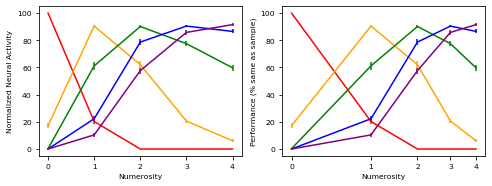

In [15]:
# Plot performance tuning functions

# Average and standard error over repetitions
tuning_mat = np.mean(100*tuning_mats, axis=0)
tuning_err = np.std(100*tuning_mats, axis=0) / np.sqrt(tuning_mats.shape[0])

# Plot on linear scale
plt.figure(figsize=(8,2.75))
plt.subplot(1,2,1)
for i, (tc, err) in enumerate(zip(tuning_mat, tuning_err)):
    plt.errorbar(Qrange, tc, err, color=colors[i])
    plt.xticks(Qrange)
plt.xlabel('Numerosity')
plt.ylabel('Normalized Neural Activity')

# Plot on log scale
plt.subplot(1,2,2)
for i, (tc, err) in enumerate(zip(tuning_mat, tuning_err)):
    plt.errorbar(Qrange+1, tc, err, color=colors[i]) # offset x axis by one to avoid taking the log of zero
    plt.xscale('log', base=2)
    plt.gca().xaxis.set_major_formatter(ScalarFormatter())
    plt.xticks(ticks=Qrange+1, labels=Qrange)
plt.xlabel('Numerosity')
plt.ylabel('Normalized Neural Activity')
        
plt.xlabel('Numerosity')
plt.ylabel('Performance (% same as sample)')

print('Average matching accuracy = %0.3f %%'%(accuracies.mean()*100))
print('Average matching accuracy for zero = %0.3f %%'%(accuracies_zero.mean()*100))
print('For zero sample numerosity: average response test numersity 1 vs 2: p-value = %e'
           %(stats.wilcoxon(tuning_mats[:,0,1], tuning_mats[:,0,2]).pvalue))

Text(0.5, 1.0, 'Random nonzero-tuned units silenced')

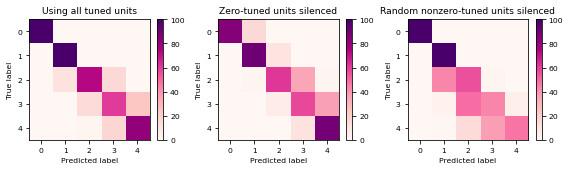

In [16]:
# Plot confusion matrices
plt.figure(figsize=(8,2.2)); cmap = 'RdPu'; interpolation="nearest"
plt.subplot(1,3,1)
plt.imshow(100*confusion_mats_correct.mean(axis=0), vmin=0, vmax=100, cmap=cmap, interpolation=interpolation); plt.colorbar()
plt.xlabel('Predicted label'); plt.ylabel('True label')
plt.title('Using all tuned units')

plt.subplot(1,3,2)
plt.imshow(100*confusion_mats_zs.mean(axis=0), vmin=0, vmax=100, cmap=cmap, interpolation=interpolation); plt.colorbar()
plt.xlabel('Predicted label'); plt.ylabel('True label');
plt.title('Zero-tuned units silenced')

plt.subplot(1,3,3)
plt.imshow(100*(confusion_mats_rs.mean(axis=0)), cmap=cmap, interpolation=interpolation); plt.colorbar()
plt.xlabel('Predicted label'); plt.ylabel('True label');
plt.tight_layout()
plt.title('Random nonzero-tuned units silenced')

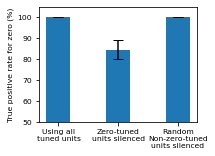

In [19]:
# Compare the effect of silencing zero-tuned units vs random nonzero-tuned units on true positive rate for zero

# Get true positive rate under different conditions
az_all = confusion_mats_correct[:,0,0]*100
az_zs = confusion_mats_zs[:,0,0]*100
az_rs = confusion_mats_rs[:,0,0]*100

plt.figure(figsize=(3,2.2))
az_means = np.array([np.mean(az_all), np.mean(az_zs), np.mean(az_rs)])
az_errors = np.array([np.std(az_all), np.std(az_zs), np.std(az_rs)]) / np.sqrt(len(az_all))
plt.bar(np.arange(3), az_means, width=0.4, yerr=az_errors, capsize=5)
plt.xticks(np.arange(3), ["Using all\ntuned units", "Zero-tuned\nunits silenced", "Random\nNon-zero-tuned\nunits silenced"])
plt.ylim([50,105])
plt.ylabel('True positive rate for zero (%)')
plt.tight_layout()

Classification accuracy in correct vs error trials: p = 7.556929455863566e-10


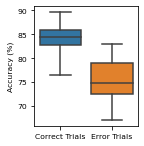

In [20]:
# Plot comparison between classification accuracy in correct vs error trials of the matching task
plt.figure(figsize=(1.85,2.2))
ax=sns.boxplot(data=[accuracies_correct*100, accuracies_error*100], whis=10)
ax.set(xticklabels=['Correct Trials', 'Error Trials'])
plt.ylabel('Accuracy (%)')
print('Classification accuracy in correct vs error trials: p =', stats.wilcoxon(accuracies_correct, accuracies_error).pvalue)